In [1]:
import simpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
import math
import random
from matplotlib.patches import Arrow
import copy

In [ ]:
# VARIABLES INICIALS
durada_simulacio = 12 * 60  # 12h en minuts
PACIENTA_MITJA = 45  # paciència mitjana del client (en minuts)

# DADES DE LES ATRACCIONS AMB DINÀMICA
atraccions_info = {
    'Big Thunder Mountain': {
        'dinamica': 'blockchain',
        'persones_per_vehicle': 30, 'nombre_vehicles': 5, 'temps_durada': 4,
        'temps_mitja_espera': 42,
        'tipus': ['nivell alt'], 'posicio': (10, 90), 'desitjat': 8.4
    },
    'Dumbo the Flying Elephant': {
        'dinamica': 'simultanea',
        'persones_per_vehicle': 3, 'nombre_vehicles': 18, 'temps_durada': 2,
        'temps_mitja_espera': 30,
        'tipus': ['infantil'], 'posicio': (20, 30), 'desitjat': 6.9
    },
    "Peter Pan's Flight": {
        'dinamica': 'omnimover',
        'persones_per_vehicle': 4, 'nombre_vehicles': 16, 'temps_durada': 5,
        'temps_mitja_espera': 46,
        'tipus': ['infantil'], 'posicio': (25, 35), 'desitjat': 7.5
    },
    'Buzz Lightyear Lazer Blast': {
        'dinamica': 'simultanea',
        'persones_per_vehicle': 2, 'nombre_vehicles': 50, 'temps_durada': 4,
        'temps_mitja_espera': 32,
        'tipus': ['nivell mitja'], 'posicio': (50, 20), 'desitjat': 5
    },
    'Autopia': {
        'dinamica': 'simultanea',
        'persones_per_vehicle': 2, 'nombre_vehicles': 50, 'temps_durada': 5,
        'temps_mitja_espera': 27,
        'tipus': ['nivell alt'], 'posicio': (60, 70), 'desitjat': 5
    },
    'Phantom Manor': {
        'dinamica': 'omnimover',
        'persones_per_vehicle': 3, 'nombre_vehicles': 131, 'temps_durada': 6,
        'temps_mitja_espera': 14,
        'tipus': ['nivell mitja'], 'posicio': (5, 95), 'desitjat': 8
    },
    "It's a small world": {
        'dinamica': 'omnimover',
        'persones_per_vehicle': 20, 'nombre_vehicles': 24, 'temps_durada': 10,
        'temps_mitja_espera': 10,
        'tipus': ['infantil'], 'posicio': (30, 40), 'desitjat': 8
    },
    'Star Wars Hyperspace Mountain': {
        'dinamica': 'blockchain',
        'persones_per_vehicle': 32, 'nombre_vehicles': 7, 'temps_durada': 2,
        'temps_mitja_espera': 23,
        'tipus': ['nivell alt'], 'posicio': (70, 10), 'desitjat': 8.7
    },
    'Star Tours the Adventures Continue': {
        'dinamica': 'simultanea',
        'persones_per_vehicle': 25, 'nombre_vehicles': 4, 'temps_durada': 4,
        'temps_mitja_espera': 20,
        'tipus': ['nivell alt'], 'posicio': (75, 15), 'desitjat': 7.4
    },
    'Pirates of the Caribbean': {
        'dinamica': 'omnimover',
        'persones_per_vehicle': 17, 'nombre_vehicles': 30, 'temps_durada': 12,
        'temps_mitja_espera': 18,
        'tipus': ['nivell mitja'], 'posicio': (15, 85), 'desitjat': 9.7
    },
    'Indiana Jones et el Temple du Peril': {
        'dinamica': 'blockchain',
        'persones_per_vehicle': 30, 'nombre_vehicles': 2, 'temps_durada': 1,
        'temps_mitja_espera': 19,
        'tipus': ['nivell alt'], 'posicio': (40, 50), 'desitjat': 9.5
    },
    'Mad Hatter’s Tea Cups': {
        'dinamica': 'simultanea',
        'persones_per_vehicle': 6, 'nombre_vehicles': 18, 'temps_durada': 2,
        'temps_mitja_espera': 10,
        'tipus': ['infantil'], 'posicio': (35, 45), 'desitjat': 5
    }
}

def espera_omnimover(cua, atraccio):
    info = atraccions_info[atraccio]
    cap_vehicle = info['persones_per_vehicle']
    n_veh = info['nombre_vehicles']
    durada = info['temps_durada']
    n_clients = len(cua.queue)
    if n_clients == 0:
        return 0.0

    # taxa de servei (clients per minut)
    taxa_servei = (n_veh * cap_vehicle) / durada
    return n_clients / taxa_servei

def espera_simultanea(cua, atraccio):
    info = atraccions_info[atraccio]
    cap_total = info['persones_per_vehicle'] * info['nombre_vehicles']
    n_clients = len(cua.queue)
    if n_clients == 0:
        return 0.0
    #tornades completes abans que arribi el teu lot
    tornades_abans = math.floor((n_clients - 1) / cap_total)
    return tornades_abans * info['temps_durada'] + atraccions_info[atraccio]['temps_durada']


def espera_blockchain(cua, atraccio):
    info = atraccions_info[atraccio]
    cap_vehicle = info['persones_per_vehicle']
    n_vehicles  = info['nombre_vehicles']
    durada_via  = info['temps_durada']
    
    #capacitat total per volta (grup de vehicles)
    capacitat_total = cap_vehicle * n_vehicles
    #headway: temps entre arribades de vehicles consecutius
    headway = durada_via / n_vehicles
    #quants clients hi ha en cua
    n_clients = len(cua.queue)
    if n_clients == 0:
        return 0.0

    #quantes rotacions de vehicles calen per servir aquestes places (cada rotació són n_vehicles vehicles arribant espaiats per headway)
    rotacions = math.ceil(n_clients / cap_vehicle)
    
    #temps fins que el vehicle que el recollirà arriba a plataforma:
    espera_per_cua = headway * (rotacions - 1) * cap_vehicle / cap_vehicle
    
    return espera_per_cua + durada_via


posicions_clients = {}

def calcula_espera(cua, atraccio):
    dinamica = atraccions_info[atraccio]['dinamica']
    
    if dinamica == 'simultanea':
        return espera_simultanea(cua, atraccio)
    elif dinamica == 'omnimover':
        return espera_omnimover(cua, atraccio)
    elif dinamica == 'blockchain':
        return espera_blockchain(cua, atraccio)
    else:
        raise ValueError(f"Tipus de dinàmica desconeguda: {dinamica}")

def generar_preferencies():
    preferencies_tipus = ['infantil', 'nivell alt', 'nivell mitja']
    preferencies = random.sample(preferencies_tipus, random.randint(1, len(preferencies_tipus)))
    return preferencies

def distancia(pos1, pos2):
    return math.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)


In [ ]:
def client(env, nom, cues, dades, paciencia, preferencies):
    registre = {
        'Client': nom,
        'Paciencia': paciencia,
        'Atraccions': [],
        'TempsArribades': [],
        'EsperesReals': [],
        'Abandonaments': 0,
        'TempsTotal': 0,
        'Valoracions': {},
        'Preferencies': preferencies
    }
    
    temps_inici = env.now
    posicio_actual = (0, 0)  # El client comença a l'entrada
    posicions_clients[nom] = {'pos': posicio_actual, 'estat': 'moviment'}
    
    
    # Selecció ponderada d'atraccions
    matching_atraccions = [
        a for a in atraccions_info 
        if any(tipus in atraccions_info[a]['tipus'] for tipus in preferencies)
    ]
    
    atraccions_pendents = []

    if matching_atraccions:
        # volem entre 6 i 10, però no més que el nombre total disponible
        n = random.randint(6, 10)
        n = min(n, len(matching_atraccions))

        attractions = matching_atraccions.copy()
        weights  = np.array([atraccions_info[a]['desitjat'] for a in attractions], dtype=float)
        weights = weights / weights.sum()
        selected_idx = np.random.choice(len(attractions), size=n, replace=False, p=weights)
        atraccions_pendents = [attractions[i] for i in selected_idx]

    atraccions_abandonades = []

    while (atraccions_pendents or atraccions_abandonades) and env.now - temps_inici <= durada_simulacio:
        if atraccions_pendents:
            llista_actual = atraccions_pendents
        else:
            llista_actual = atraccions_abandonades

        esperes = {a: calcula_espera(cues[a], a) for a in llista_actual}
        millor_espera = min(esperes.values())
        candidats = [a for a in esperes if esperes[a] == millor_espera]

        if len(candidats) > 1:
            atraccio = min(candidats, key=lambda a: distancia(posicio_actual, atraccions_info[a]['posicio']))
        else:
            atraccio = candidats[0]

        if esperes[atraccio] > paciencia:
            if atraccio in atraccions_pendents:
                atraccions_pendents.remove(atraccio)
                atraccions_abandonades.append(atraccio)
            elif atraccio in atraccions_abandonades:
                atraccions_abandonades.remove(atraccio)
            registre['Abandonaments'] += 1
            registre['Atraccions'].append(f"{atraccio} (X)")
            registre['TempsArribades'].append(env.now)
            registre['EsperesReals'].append(paciencia)
            registre['Valoracions'][f"{atraccio} (X)"] = 0
            posicions_clients[nom]['estat'] = 'abandonat'
            continue

        # Moviment fins l'atracció
        distancia_mou = distancia(posicio_actual, atraccions_info[atraccio]['posicio'])
        temps_moviment = max(1, int(distancia_mou / 5))
        yield env.timeout(temps_moviment)
        temps_arribada = env.now
        posicio_actual = atraccions_info[atraccio]['posicio']
        posicions_clients[nom]['pos'] = posicio_actual
        posicions_clients[nom]['estat'] = 'cua'

        # Modificar la gestió de la cua segons la dinàmica de la atracció:
        start_wait = env.now
        if atraccions_info[atraccio]['dinamica'] == 'simultanea':
            with cues[atraccio].request() as req:
                result = yield req | env.timeout(paciencia)
                stop_wait = env.now
                yield env.timeout(atraccions_info[atraccio]['temps_durada'])
            
        elif atraccions_info[atraccio]['dinamica'] == 'omnimover':
            #es un fluxe constant, els clients es mouen de manera continua
            with cues[atraccio].request() as req:
                result = yield req | env.timeout(paciencia)
                # Simula que el fluxe de persones es mouen de manera continua, sense temps d'espera llargs
                yield env.timeout(0.5)  # Simulem un temps molt curt d'espera constant
                stop_wait = env.now
                yield env.timeout(atraccions_info[atraccio]['temps_durada'])
            
        else:
            with cues[atraccio].request() as req:
                result = yield req | env.timeout(paciencia)
                stop_wait = env.now
                yield env.timeout(atraccions_info[atraccio]['temps_durada'])
        
        temps_a_cua = stop_wait - start_wait

        if req not in result:
            if atraccio in atraccions_pendents:
                atraccions_pendents.remove(atraccio)
                atraccions_abandonades.append(atraccio)
            registre['Abandonaments'] += 1
            registre['Atraccions'].append(f"{atraccio} (X)")
            registre['TempsArribades'].append(env.now)
            registre['EsperesReals'].append(temps_a_cua)
            registre['Valoracions'][f"{atraccio} (X)"] = 0
            posicions_clients[nom]['estat'] = 'abandonat'
            continue

        posicions_clients[nom]['estat'] = 'atraccio' #Està pujant a l'atracció

        registre['EsperesReals'].append(temps_a_cua)
        registre['Atraccions'].append(atraccio)
        registre['TempsArribades'].append(temps_arribada)

        if atraccio in atraccions_pendents:
            atraccions_pendents.remove(atraccio)
        elif atraccio in atraccions_abandonades:
            atraccions_abandonades.remove(atraccio)

    # Valoracions
    if registre['Atraccions']:
        for atraccio in registre['Atraccions']:
            if '(X)' not in atraccio:
                registre['Valoracions'][atraccio] = random.uniform(0, 10)

    atraccions_visitades = [a for a in registre['Valoracions'] if '(X)' not in a]
    atraccions_visitades_ordenades = sorted(atraccions_visitades, key=lambda x: registre['Valoracions'][x], reverse=True)

    # Intentem repetir les atraccions si queda temps i el client no ha abandonat
    while atraccions_visitades_ordenades and env.now - temps_inici <= durada_simulacio:
        atraccio = atraccions_visitades_ordenades[0]

        distancia_mou = distancia(posicio_actual, atraccions_info[atraccio]['posicio'])
        temps_moviment = max(1, int(distancia_mou / 5))
        yield env.timeout(temps_moviment)
        temps_arribada = env.now
        posicio_actual = atraccions_info[atraccio]['posicio']
        posicions_clients[nom]['pos'] = posicio_actual
        posicions_clients[nom]['estat'] = 'cua'

        with cues[atraccio].request() as req:
            start_wait = env.now
            result = yield req | env.timeout(paciencia)

            if req not in result:
                registre['Abandonaments'] += 1
                temps_a_cua = env.now - start_wait
                registre['Atraccions'].append(f"{atraccio} (X) (REP)")
                registre['TempsArribades'].append(env.now)
                registre['EsperesReals'].append(temps_a_cua)
                registre['Valoracions'][f"{atraccio} (X) (REP)"] = 0
                posicions_clients[nom]['estat'] = 'abandonat'
                atraccions_visitades_ordenades.pop(0)
                continue

            espera_real = env.now - start_wait
            registre['EsperesReals'].append(espera_real)
            registre['Atraccions'].append(f"{atraccio} (REP)")
            registre['TempsArribades'].append(temps_arribada)
            registre['Valoracions'][f"{atraccio} (REP)"] = random.uniform(0, 10)

            posicions_clients[nom]['estat'] = 'atraccio'
            yield env.timeout(atraccions_info[atraccio]['temps_durada'])

    registre['TempsTotal'] = env.now

    dades.append(registre) 

In [ ]:
def prepara_clients(total_clients):
    clients = []
    for i in range(total_clients):
        paciencia = max(5, np.random.normal(PACIENTA_MITJA, 10))
        preferencies = generar_preferencies()
        clients.append((f'Client_{i:05d}', paciencia, preferencies))
    return clients


def run_simulacio():
    env = simpy.Environment()
    cues = {}
    for nom, info in atraccions_info.items():
        if info['dinamica'] == 'simultanea':
            capacity = info['persones_per_vehicle'] * info['nombre_vehicles']
        elif info['dinamica'] == 'omnimover':
            capacity = info['persones_per_vehicle'] * info['nombre_vehicles']
        else:#(blockchain)
            capacity = info['persones_per_vehicle']
        cues[nom] = simpy.Resource(env, capacity=capacity)

    dades = []

    # Prepara tots els clients abans de començar
    total_clients = 12000
    clients = prepara_clients(total_clients)

    for client_id, paciencia, preferencies in clients:
        env.process(client(
            env,
            client_id,
            cues,
            dades,
            paciencia,
            preferencies
        ))

    env.run()
    return pd.DataFrame(dades)

# Execució principal
df = run_simulacio()


In [5]:
print(f"Clients generats: {len(df)}")
print(f"Mitjana d'abandonaments: {df['Abandonaments'].mean():.2f}")
print(f"Temps total d'espera màxim registrat: {max(df['EsperesReals'].max())} minuts")
esperes_totals = list(chain.from_iterable(df['EsperesReals'].dropna()))
print(f"Espera mitjana: {np.mean(esperes_totals):.2f} minuts")


Clients generats: 12000
Mitjana d'abandonaments: 4.46
Temps total d'espera màxim registrat: 65.13967014027418 minuts
Espera mitjana: 20.83 minuts


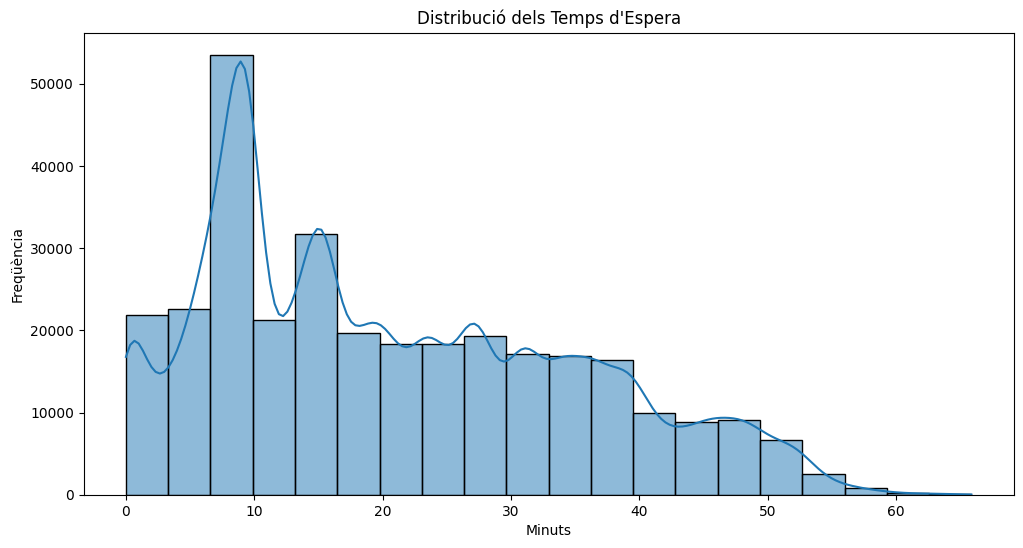

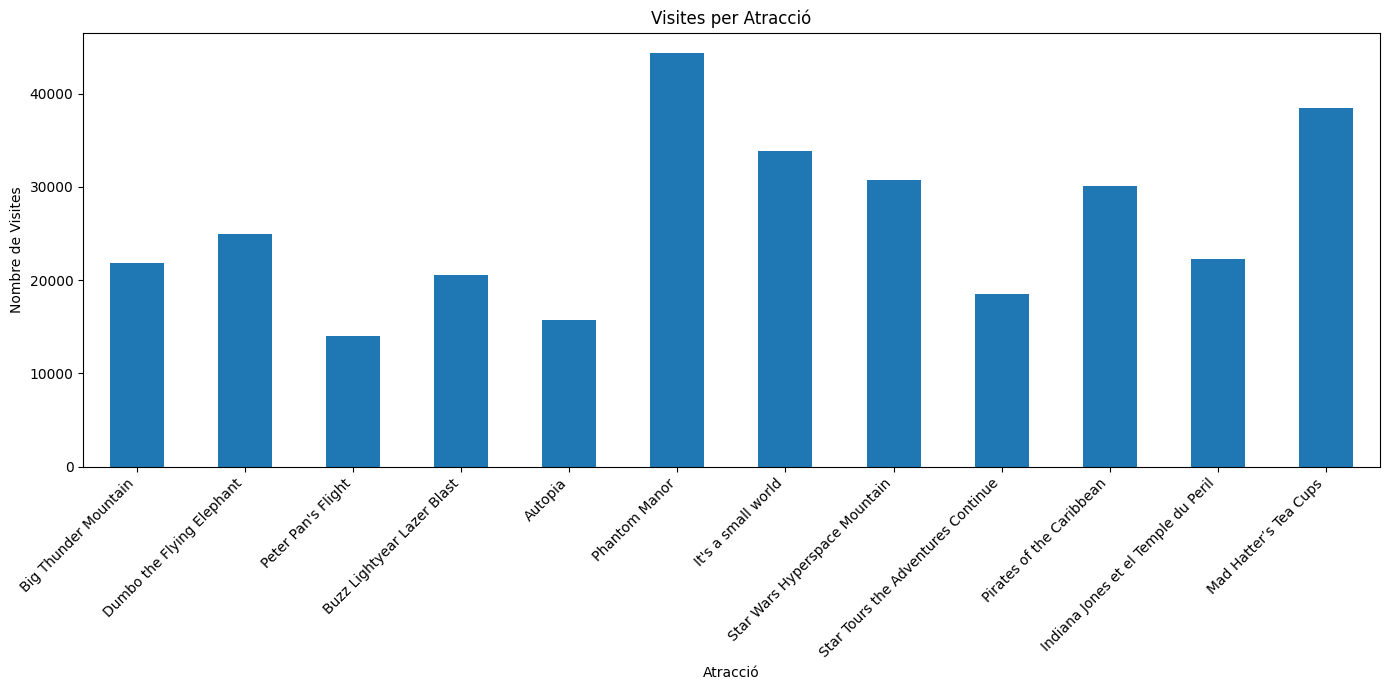

In [ ]:
plt.figure(figsize=(12,6))
sns.histplot(esperes_totals, bins=20, kde=True)
plt.title("Distribució dels Temps d'Espera")
plt.xlabel("Minuts")
plt.ylabel("Freqüència")

atraplats = df['Atraccions'].explode().dropna().astype(str)
atraccions_net = atraplats.str.replace(r"\s*\(.*\)", "", regex=True)

visites_per_atraccio = atraccions_net.value_counts().reindex(
    list(atraccions_info.keys()), fill_value=0
)

plt.figure(figsize=(14,7))
visites_per_atraccio.plot(kind='bar')
plt.title("Visites per Atracció")
plt.xlabel("Atracció")
plt.ylabel("Nombre de Visites")
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


=== Anàlisi de Temps d'Espera per Atracció ===
                                     Esperat (Real)  Observat (Simulat)  \
Star Wars Hyperspace Mountain                    28           34.582896   
Dumbo the Flying Elephant                        25           29.885324   
Mad Hatter’s Tea Cups                             9           11.176433   
Big Thunder Mountain                             43           45.008868   
Indiana Jones et el Temple du Peril              18           18.805335   
Star Tours the Adventures Continue               22           22.182231   
Buzz Lightyear Lazer Blast                       30           29.967711   
Pirates of the Caribbean                         17           15.463970   
Autopia                                          27           24.091587   
Peter Pan's Flight                               41           37.511709   
It's a small world                               10            6.447328   
Phantom Manor                                    13  

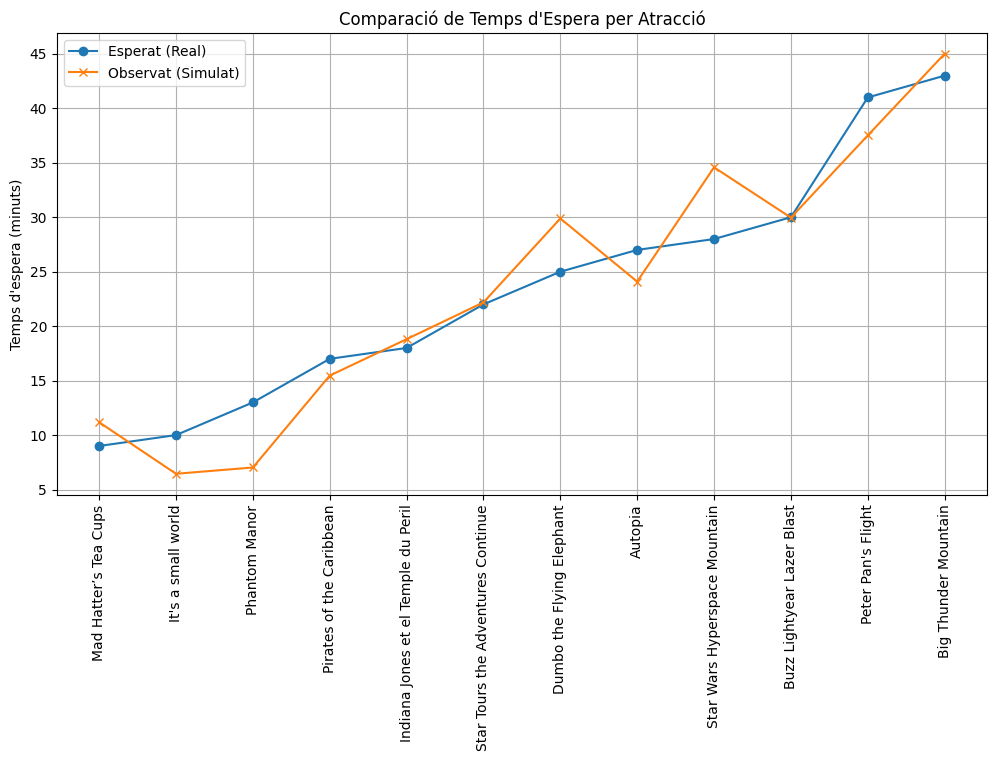

In [ ]:
def analisi_temps_espera(df):
    print("=== Anàlisi de Temps d'Espera per Atracció ===")
    
    # Recollim totes les dades d'espera real agrupades per atracció
    espera_dades = {}
    for idx, fila in df.iterrows():
        for atraccio, espera in zip(fila['Atraccions'], fila['EsperesReals']):
            # Ignorem abandonaments (atraccions marcades amb (X))
            nom_atraccio = atraccio.replace(' (X)', '').replace(' (REP)', '').replace(' (X) (REP)', '')
            if nom_atraccio not in espera_dades:
                espera_dades[nom_atraccio] = []
            espera_dades[nom_atraccio].append(espera)
    
    # Calculem mitjanes observades (simulació)
    observats = {atraccio: np.mean(esperes) for atraccio, esperes in espera_dades.items()}
    teorics = {atraccio: info['temps_mitja_espera'] for atraccio, info in atraccions_info.items()}
    
    df_espera = pd.DataFrame({
        'Esperat (Real)': teorics,
        'Observat (Simulat)': observats
    })
    df_espera['Diferencia (Obs - Esperat)'] = df_espera['Observat (Simulat)'] - df_espera['Esperat (Real)']
    
    print(df_espera.sort_values('Diferencia (Obs - Esperat)', ascending=False))
    
    plt.figure(figsize=(12, 6))
    df_espera_sorted = df_espera.sort_values('Esperat (Real)')
    plt.plot(df_espera_sorted.index, df_espera_sorted['Esperat (Real)'], label='Esperat (Real)', marker='o')
    plt.plot(df_espera_sorted.index, df_espera_sorted['Observat (Simulat)'], label='Observat (Simulat)', marker='x')
    plt.xticks(rotation=90)
    plt.ylabel('Temps d\'espera (minuts)')
    plt.title('Comparació de Temps d\'Espera per Atracció')
    plt.legend()
    plt.grid(True)
    plt.show()

analisi_temps_espera(df)
